In [1]:
# imports
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import scipy.stats as sstats
from os.path import join, exists
from sklearn.metrics import matthews_corrcoef

In [2]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [3]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data.csv"), index_col=0, header=0)

In [4]:
df["interview_date.2_year_follow_up_y_arm_1"].isna().sum()

3958

In [5]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna()
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [6]:
print(f'smri cols: {len(deltasmri_complete.columns)}')
print(f'rsfmri cols: {len(deltarsfmri_complete.columns)}')
print(f'rsi cols: {len(deltarsi_complete.columns)}')
print(f'dti cols: {len(deltadti_complete.columns)}')


smri cols: 785
rsfmri cols: 758
rsi cols: 122
dti cols: 111


In [7]:
imaging_qc = [
    "imgincl_dmri_include.baseline_year_1_arm_1",
    "imgincl_rsfmri_include.baseline_year_1_arm_1",
    "imgincl_t1w_include.baseline_year_1_arm_1",
    "imgincl_t2w_include.baseline_year_1_arm_1",
    "imgincl_dmri_include.2_year_follow_up_y_arm_1",
    "imgincl_rsfmri_include.2_year_follow_up_y_arm_1",
    "imgincl_t1w_include.2_year_follow_up_y_arm_1",
    "imgincl_t2w_include.2_year_follow_up_y_arm_1",
]
nihtb = [
    "nihtbx_picvocab_uncorrected.change_score",
    #"nihtbx_flanker_uncorrected.change_score",
    #'nihtbx_list_uncorrected.change_score',
    #'nihtbx_cardsort_uncorrected.change_score',
    "nihtbx_pattern_uncorrected.change_score",
    "nihtbx_picture_uncorrected.change_score",
    "nihtbx_reading_uncorrected.change_score",
]
puberty = [  #'sex.baseline_year_1_arm_1', 'sex.2_year_follow_up_y_arm_1',
    "pds_p_ss_male_category_2.baseline_year_1_arm_1",
    "pds_p_ss_female_category_2.baseline_year_1_arm_1",
    "pds_p_ss_male_category_2.2_year_follow_up_y_arm_1",
    "pds_p_ss_female_category_2.2_year_follow_up_y_arm_1",
]
demographics = [
    "demo_prnt_ethn_v2.baseline_year_1_arm_1",
    "demo_prnt_marital_v2.baseline_year_1_arm_1",
    "demo_prnt_ed_v2.baseline_year_1_arm_1",
    "demo_comb_income_v2.baseline_year_1_arm_1",
    "demo_race_a_p___10.baseline_year_1_arm_1",
    "demo_race_a_p___11.baseline_year_1_arm_1",
    "demo_race_a_p___12.baseline_year_1_arm_1",
    "demo_race_a_p___13.baseline_year_1_arm_1",
    "demo_race_a_p___14.baseline_year_1_arm_1",
    "demo_race_a_p___15.baseline_year_1_arm_1",
    "demo_race_a_p___16.baseline_year_1_arm_1",
    "demo_race_a_p___17.baseline_year_1_arm_1",
    "demo_race_a_p___18.baseline_year_1_arm_1",
    "demo_race_a_p___19.baseline_year_1_arm_1",
    "demo_race_a_p___20.baseline_year_1_arm_1",
    "demo_race_a_p___21.baseline_year_1_arm_1",
    "demo_race_a_p___22.baseline_year_1_arm_1",
    "demo_race_a_p___23.baseline_year_1_arm_1",
    "demo_race_a_p___24.baseline_year_1_arm_1",
    "demo_race_a_p___25.baseline_year_1_arm_1",
]
age = [  #'mri_info_manufacturer.baseline_year_1_arm_1',
    #'mri_info_manufacturer.2_year_follow_up_y_arm_1',
    "interview_age.baseline_year_1_arm_1",
    "interview_age.2_year_follow_up_y_arm_1",
]
family = ["rel_family_id.baseline_year_1_arm_1", 
          "rel_group_id.baseline_year_1_arm_1", 
          "rel_ingroup_order.baseline_year_1_arm_1", 
          "rel_relationship.baseline_year_1_arm_1"]
site = ["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"]
sex = ["sex.baseline_year_1_arm_1", "sex.2_year_follow_up_y_arm_1"]

In [8]:
sex = pd.get_dummies(df[["sex.baseline_year_1_arm_1", "sex.2_year_follow_up_y_arm_1"]])
sex_cols = list(sex.columns)
df = pd.concat([df, sex], axis=1)
df.drop(
    ["sex.baseline_year_1_arm_1", "sex.2_year_follow_up_y_arm_1"], axis=1, inplace=True
)
mri = pd.get_dummies(
    df[
        [
            "mri_info_manufacturer.baseline_year_1_arm_1",
            "mri_info_manufacturer.2_year_follow_up_y_arm_1",
        ]
    ]
)
mri_cols = list(mri.columns)
df = pd.concat([df, mri], axis=1)
df.drop(
    [
        "mri_info_manufacturer.baseline_year_1_arm_1",
        "mri_info_manufacturer.2_year_follow_up_y_arm_1",
    ],
    axis=1,
    inplace=True,
)
site = pd.get_dummies(
    df[["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"]]
)
#site_cols = list(site.columns)#
#df = df = pd.concat([df, site], axis=1)
#df.drop(
#    ["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"],
#    axis=1,
#    inplace=True,
#)
site_cols = ["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"]

What am I going to do?
If I add baseline and 2yfu imaging QC variables then any value less than 2 is an exclude.
and I can convert everything less than 2 to np.nan to use for missingness assessments. 
Need to find out what the "mean motion" value is. FD? yes, in mm.

In [9]:
# build a mini dataset that represents missingness on each variable
keep = nihtb + puberty + demographics + age + family + sex_cols + mri_cols + site_cols
miss_df = df[keep]

In [10]:
missing = miss_df.isna().replace({True: 1, False: 0})

for col1 in missing:
    for col2 in miss_df:
        if col1 != col2:
            temp_df = pd.concat([missing[col1], miss_df[col2]], axis=1)
            temp_df.dropna(how="any", inplace=True)
            if len(miss_df[col2].dropna().unique()) == 2:
                mcc = matthews_corrcoef(temp_df[col1].values, temp_df[col2].values)
                print(
                    f"{col1} missingness assoc with {col2} value\nmcc = {np.round(mcc, 4)}"
                )
            else:
                pbr = sstats.pointbiserialr(temp_df[col1].values, temp_df[col2].values)
                if pbr[1] < 0.01:
                    print(
                        f"{col1} missingness assoc with {col2} value\nr = {np.round(pbr[0], 4)}\t\tp = {np.round(pbr[1], 4)}"
                    )
                else:
                    pass
        else:
            pass

missing.corr(method="kendall")

# grab imaging var names bc missingness is redundant across those
dmri_rgx = 'dmri.*'
dmri_cols = df.filter(regex=dmri_rgx, axis=1).columns
smri_rgx = 'smri.*'
smri_cols = df.filter(regex=smri_rgx, axis=1).columns
fmri_rgx = 'rsfmri.*'
fmri_cols = df.filter(regex=fmri_rgx, axis=1).columns

In [11]:
# using ABCD's inclusion criteria to further mask the data
# add include from baseline and y2, then convert all values <2 to nan

modalities = ["t1w", "dmri", "t2w", "rsfmri"]
for modality in modalities:
    missing = pd.Series(index=miss_df.index)
    missing = (
        df[f"imgincl_{modality}_include.baseline_year_1_arm_1"]
        + df[f"imgincl_{modality}_include.2_year_follow_up_y_arm_1"]
    )
    for i in miss_df.index:
        if missing.loc[i] == 2.0:
            miss_df.loc[i, f"{modality}_missing"] = 1
        else:
            miss_df.loc[i, f"{modality}_missing"] = np.nan

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

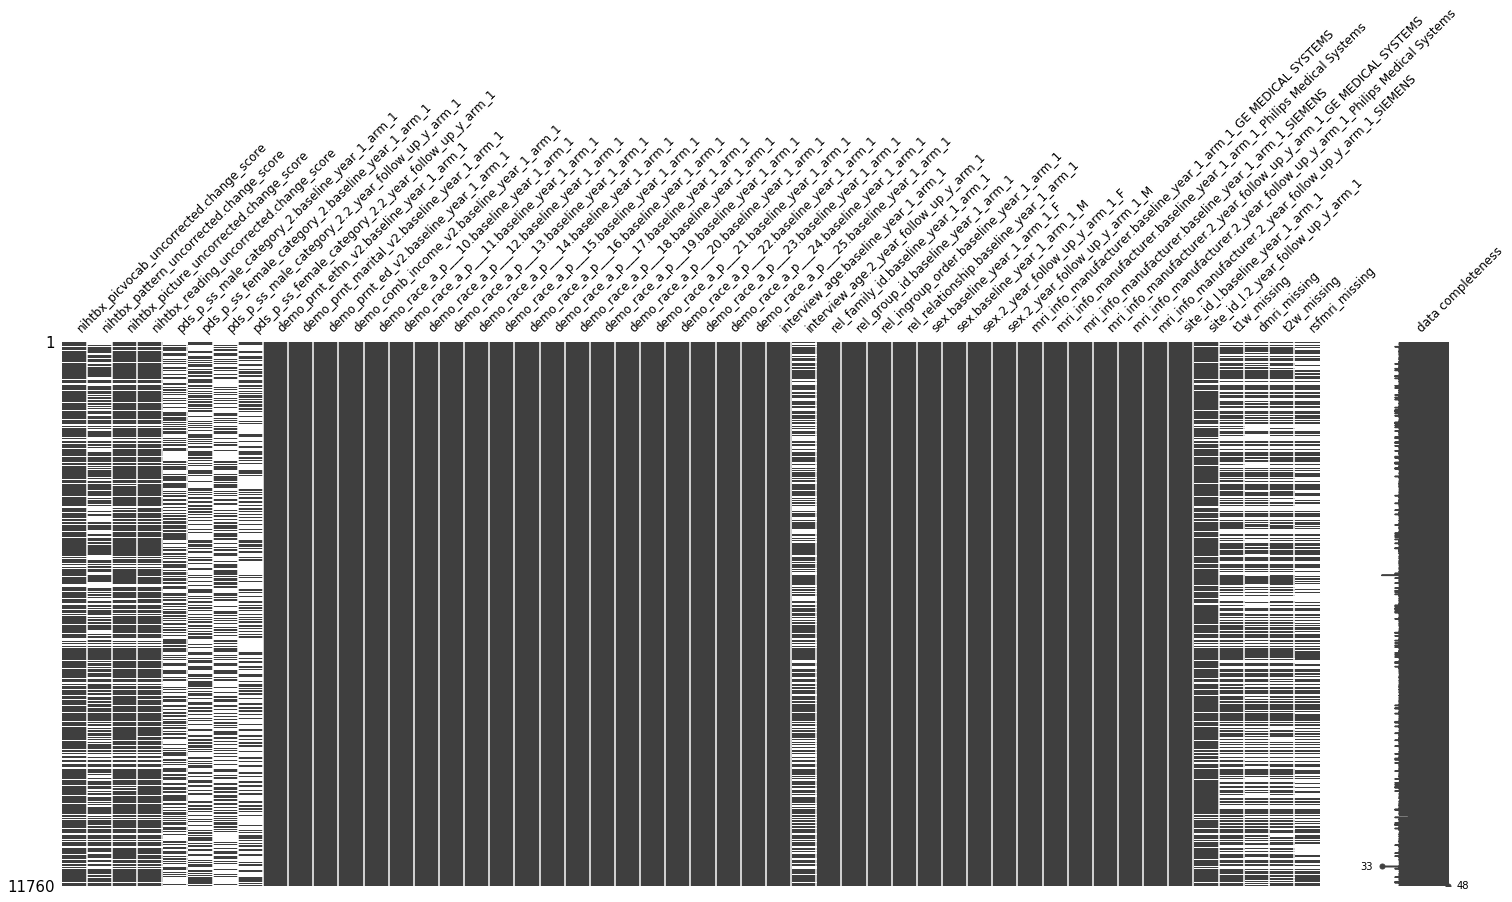

In [12]:
msno.matrix(miss_df, labels=True, fontsize=12)

In [13]:
# calculate percent misingness on each var
pct_miss = miss_df.isna().sum() / len(miss_df.index)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
smri_comp = pca.fit_transform(deltasmri_complete)
rsfmri_comp = pca.fit_transform(deltarsfmri_complete)
rsi_comp = pca.fit_transform(deltarsi_complete)
dti_comp = pca.fit_transform(deltadti_complete)

In [15]:
smri_components = pd.DataFrame(index=deltasmri_complete.index, 
                               data=smri_comp, 
                               columns=['smri1', 'smri2', 'smri3'])
rsfmri_components = pd.DataFrame(index=deltarsfmri_complete.index, 
                                 data=rsfmri_comp, 
                                 columns=['rsfmri1', 'rsfmri2', 'rsfmri3'])
rsi_components = pd.DataFrame(index=deltarsi_complete.index, 
                              data=rsi_comp, 
                              columns=['rsi1', 'rsi2', 'rsi3'])
dti_components = pd.DataFrame(index=deltadti_complete.index, 
                              data=dti_comp, 
                              columns=['dti1', 'dti2', 'dti3'])

In [16]:
miss_w_comps = pd.concat([miss_df, smri_components, rsfmri_components, rsi_components, dti_components], axis=1)

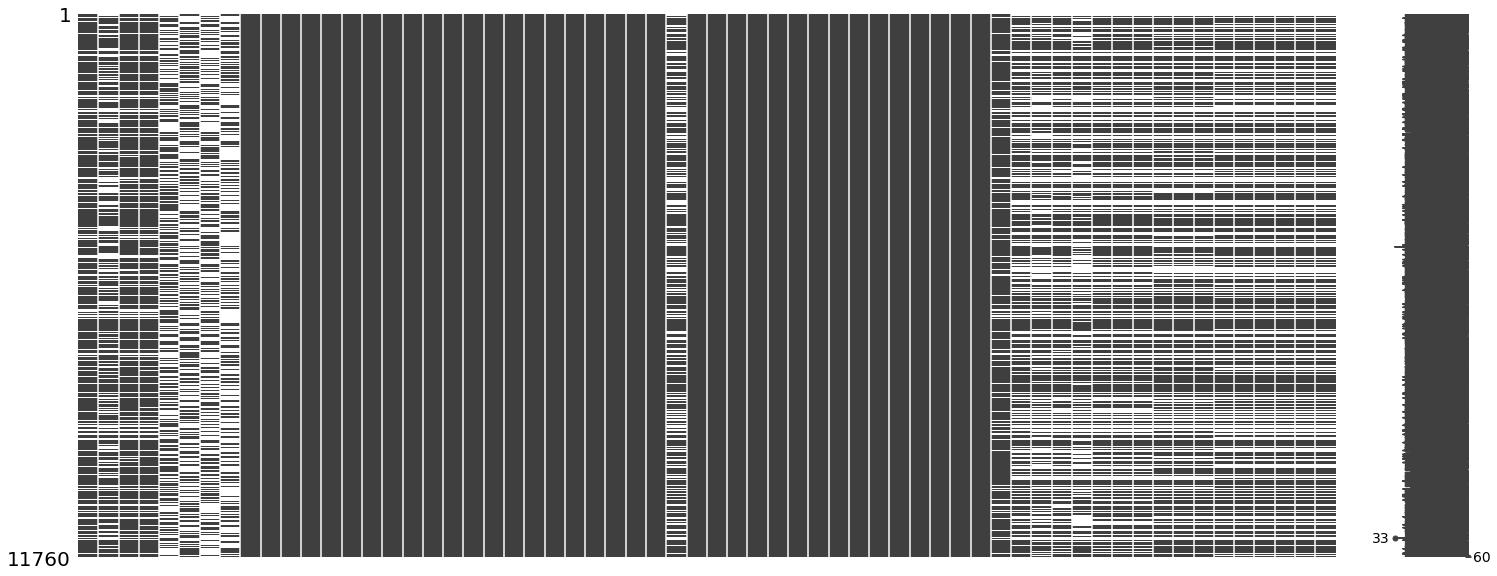

In [17]:
msno.matrix(miss_w_comps)

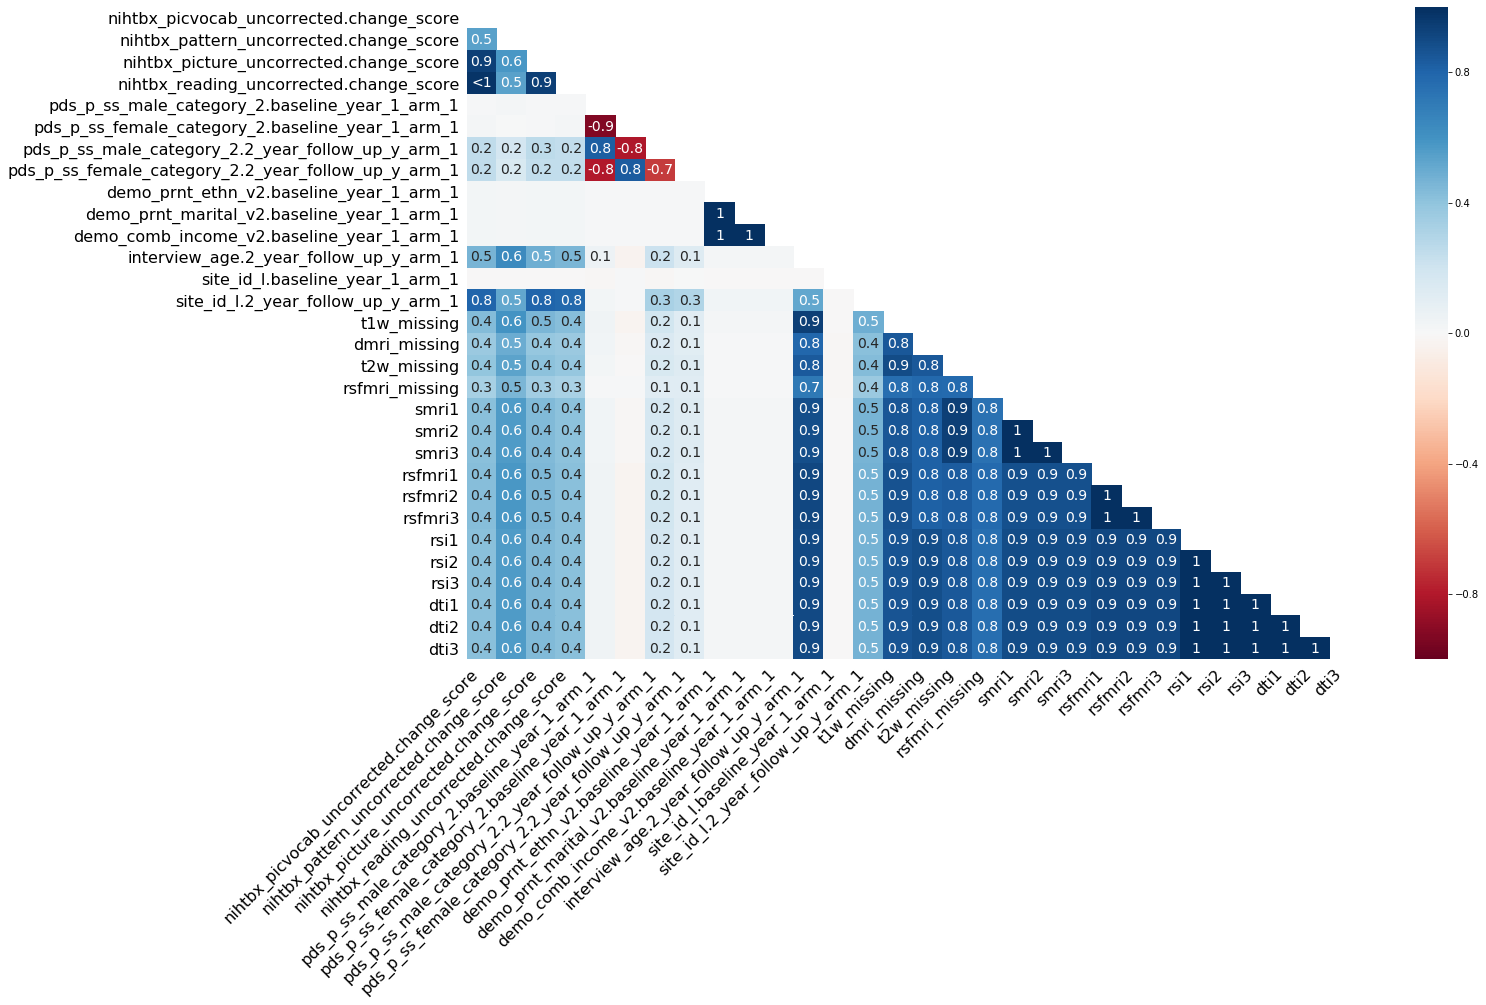

In [18]:
msno.heatmap(miss_w_comps)

In [19]:
miss_w_comps.to_csv(join(PROJ_DIR, DATA_DIR, 'img_components_and_data.csv'))